# 5. Validación Modelado de Agente Vigilante


Este notebook tiene como objetivo **evaluar y validar el desempeño del Agente Vigilante**, un modelo basado en LLM (Large Language Model) diseñado para **clasificar normativas tributarias chilenas** en función de su relevancia y contexto normativo.  

La clasificación se realiza a partir de:

- **Corpus normativo:** Conjunto de documentos legales y normativos relacionados con la tributación en Chile.  
- **Vectorstore:** Base de datos de embeddings utilizada para recuperación semántica de textos.  
- **Modelo LLM:** Responsable de inferir la relevancia de cada normativa, generar explicaciones y medir coherencia entre predicciones y etiquetas reales.  

Este proceso tiene como finalidad:

- Identificar **normativas relevantes** frente a las reglas de negocio previamente definidas.  
- Evaluar el comportamiento del agente frente a un dataset conocido para medir **accuracy, precision, recall y F1-score**.  
- Analizar el **tiempo de respuesta y consumo de tokens** por modelo para optimizar el desempeño del agente.  

Con este notebook se busca **generar evidencia cuantitativa y visual** que permita seleccionar el mejor modelo y ajustar los parámetros del Agente Vigilante antes de su implementación en un entorno productivo.


## 5.1 Objetivos y Alcance

El propósito de este notebook es **evaluar la efectividad y eficiencia del Agente Vigilante** en la clasificación de normativas tributarias chilenas, utilizando diferentes configuraciones de modelos de lenguaje (LLM) y parámetros de búsqueda semántica.

### 5.1.1 Objetivos específicos

- **Medir el desempeño del agente** mediante métricas cuantitativas (Accuracy, Precision, Recall y F1-score).  
- **Analizar errores de clasificación**, identificando falsos positivos y falsos negativos para mejorar la calidad del modelo.  
- **Evaluar el consumo de recursos**, incluyendo:
  - Tiempo promedio de ejecución por petición.
  - Tokens de entrada y salida utilizados por cada modelo.  
- **Comparar distintos modelos LLM y configuraciones de KNN** para determinar cuál ofrece el mejor equilibrio entre precisión y eficiencia.  
- **Generar reportes visuales** (tablas y gráficos) que permitan interpretar fácilmente los resultados obtenidos.

### 5.1.2  Alcance

Este análisis se limita a:

- Normativas tributarias previamente cargadas en la base vectorial.  
- Modelos LLM seleccionados en esta versión del experimento (GPT-4, GPT-4.1 Mini, Gemini, entre otros).  
- Procesos de evaluación en entorno de prueba, sin conexión directa a un sistema productivo.

El alcance de este notebook es **experimental**, y los resultados servirán como base para futuras optimizaciones y la eventual puesta en producción del Agente Vigilante.


In [326]:
# library
import pandas as pd
import tiktoken
from langchain_community.vectorstores import Redis

import os
from tqdm import tqdm
import time

from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.callbacks import get_openai_callback

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [327]:

# -------------------------------
# CONSTANTS
# -------------------------------
REDIS_HOST = "localhost"
REDIS_PORT = 6379
REDIS_DB = 0
REDIS_USERNAME = "default"
REDIS_PASSWORD = ""
REDIS_INDEX = "normativas_sii"
REDIS_URL = f"redis://{REDIS_USERNAME}:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}/{REDIS_DB}"


CUSTOM_PALETTE = [
    "#677023", "#F3A7CC", "#5B6E86", "#FF5C73", "#B2A2D6",
    "#DBFF00", "#FFB300", "#212121", "#FEF9ED", "#B4FF00",
    "#F9DA00", "#DAB9CE", "#FFEDD6", "#3D8B84", "#D1B660"
]

cmap_custom = ListedColormap(CUSTOM_PALETTE[0])
# -------------------------------
DATA_DIR ="../raw_data"
MODEL_NAME = "text-embedding-3-large" 
# Tokenizador para OpenAI embeddings
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)
SAFE_TOKENS = 30000  # margen de seguridad

INDEX_NAME = REDIS_INDEX
K = 5  # Número de documentos similares desde Redis
YEARS=[2025]


In [328]:
# -------------------------------
# FUNCTIONS
# -------------------------------

def truncar_a_tokens(texto: str, max_tokens: int = SAFE_TOKENS) -> str:
    """
    Trunca un texto para que no supere un número máximo de tokens según el tokenizador configurado.

    - Codifica el texto a tokens usando el tokenizador.
    - Corta la secuencia al máximo permitido (max_tokens).
    - Decodifica y retorna el texto truncado.

    Parámetros:
    - texto (str): Texto de entrada a truncar.
    - max_tokens (int, opcional): Límite máximo de tokens permitidos (por defecto SAFE_TOKENS).

    Retorna:
    - str: Texto resultante, truncado para no superar el número de tokens especificado.

    Notas:
    - Usa el tokenizador global 'tokenizer'.
    - Es útil para ajustar textos a los límites de modelos de lenguaje o sistemas de indexación.
    """
    tokens = tokenizer.encode(texto)
    return tokenizer.decode(tokens[:max_tokens])


def contar_tokens(texto: str) -> int:
    """
    Cuenta la cantidad de tokens en un texto utilizando el tokenizador configurado.

    - Convierte el texto a una secuencia de tokens según el tokenizador global.
    - Devuelve la cantidad total de tokens resultante.

    Parámetros:
    - texto (str): Texto de entrada a analizar.

    Retorna:
    - int: Número de tokens en el texto proporcionado.

    Notas:
    - Utiliza la variable o función global 'tokenizer'.
    - Útil para validar límites de entrada en modelos de lenguaje o indexación de textos.
    """
    return len(tokenizer.encode(texto))

def truncar_a_tokens(texto: str, max_tokens: int) -> str:
    tokens = tokenizer.encode(texto)
    return texto if len(tokens) <= max_tokens else tokenizer.decode(tokens[:max_tokens])

def parsear_respuesta(response: dict):
    # Intentar obtener el texto en distintas claves
    respuesta = response.get("text") or response.get("respuesta", "")
  
    relevancia = "No Relevante"
    explicacion = "No se pudo interpretar respuesta"
    for line in respuesta.split("\n"):
        if line.lower().startswith("relevancia:"):
            relevancia = line.split(":", 1)[1].strip()
        elif line.lower().startswith("explicación:") or line.lower().startswith("explicacion:"):
            explicacion = line.split(":", 1)[1].strip()
    return relevancia, explicacion


def safe_int(val):
    try:
        return int(val)
    except (ValueError, TypeError):
        return None

In [329]:
template = """Eres un asistente legal experto en normativas tributarias chilenas, especializado en sistemas de cumplimiento normativo automatizado para una fintech.

Tu tarea es determinar si una nueva normativa es **Relevante** o **No Relevante** para este sistema, en base al contexto proporcionado.

Clasifica como **Relevante** únicamente si la normativa se relaciona directamente con alguno de los siguientes temas:  
- boletas
- comprobantes electrónicos  
- registro de compra  
- registro de venta  
- cumplimiento tributario  
- inicio de actividades  
- medios de pago electrónicos  
- POS o puntos de venta  
- operadores y administradores  
- comercio electrónico
- psp (proveedores de servicios para procesamiento de pagos)


También puedes considerar coincidencias sustantivas con normativas similares ya catalogadas como relevantes en el contexto.

**No clasifiques como Relevante normativas que solamente:**
- regulan convenios o acuerdos institucionales,  
- establecen procedimientos internos del SII,  
- fijan nóminas, listados o autorizaciones individuales,  
a menos que modifiquen directamente procesos generales que afecten el cumplimiento automatizado de la fintech.

Si la normativa no trata explícitamente alguno de los temas definidos o no representa un cambio general, clasifica como **No Relevante**.

---

📄 **Contexto de normativas similares clasificadas previamente:**  
{context}

---

📘 **Nueva normativa:**  
{normativa}

---

Responde estrictamente en el siguiente formato (sin agregar texto adicional):

Relevancia: [Relevante|No Relevante]  
Explicación: [explicación clara y específica que justifique la decisión, o 'No cumple reglas de negocio' si corresponde]
"""



## 5.2  Configuración del agente
- **Definición de parámetros**:
  - Modelos LLM a evaluar.
  - Número de vecinos (KNN) a recuperar en la búsqueda semántica.
  - Factores de truncado de tokens para optimizar el contexto enviado al modelo.
- **Construcción de la cadena de inferencia (LLMChain)** para estructurar los prompts y capturar las respuestas del modelo.

### 5.2.1 Ejecución de las pruebas
- **Clasificación automatizada** de cada normativa mediante el Agente Vigilante.
- **Recuperación de contexto** desde el vectorstore para enriquecer la entrada al modelo.
- **Obtención de predicciones** (Relevante / No Relevante) y generación de explicación asociada.

### 5.2.2 Evaluación de resultados
- **Cálculo de métricas de rendimiento**:
  - Accuracy, Precision, Recall y F1-score.
- **Detección de errores de clasificación**:
  - Falsos positivos y falsos negativos con sus explicaciones reales vs predichas.
- **Análisis de eficiencia**:
  - Tiempo de ejecución por petición.
  - Tokens de entrada y salida consumidos por modelo.




In [330]:
class AgenteVigilante:
    """
    Agente para clasificar normativas tributarias chilenas en base a contexto y reglas de negocio.
    Utiliza un modelo de lenguaje para determinar relevancia y proporcionar explicaciones.
    """

    def __init__(self, name: str, chain, factor=None, out_file: str = None, checkpoint: bool = True, vectorstore=None):
        """
        Inicializa el agente con el modelo de lenguaje y configuración de OpenAI.
        """
        self.name = name
        self.chain = chain
        self.vectorstore = vectorstore
        self.factor = factor or [0.8, 0.6, 0.4, 0.2]
        self.checkpoint = checkpoint
        self.out_file = out_file
        self.resultados_globales = []
        self.modelo = chain.llm.name if hasattr(chain, 'llm') else "Desconocido"
        
     

    def run(self, items: pd.DataFrame, lote: int = 10, knn: int = 5, val_score=0.75) -> pd.DataFrame:
        resultados_lote = []

        # ✅ Reanudar si ya existe checkpoint
        if self.checkpoint and os.path.exists(self.out_file):
            prev = pd.read_csv(self.out_file)
            procesadas = set(prev["nombre"])
            items = items[~items["nombre"].isin(procesadas)]
            print(f"🔄 Reanudando. Saltadas {len(procesadas)} normativas ya procesadas.")

        
        for _, row in tqdm(items.iterrows(), total=len(items), desc="🔍 Clasificando normativas"):
            texto_original = str(row["corpus"]).strip()
            metadatos = {
                "nombre": row.get("nombre", ""),
                "descripcion": row.get("descripcion", ""),
                "fuente": row.get("fuente", ""),
                "url": row.get("url", ""),
                "tipo_documento": row.get("tipo_documento", ""),
                "anno": safe_int(row.get("anno", "")),
                "n_tokens": safe_int(contar_tokens(texto_original)),
                "relevancia": row.get("relevancia", ""),
                "explicacion": row.get("explicacion", "").strip(),
                "exitos": row.get("exitos", 0) if "exitos" in row else 0,
                "peso": row.get("peso", 0) if "peso" in row else 0,
            }

            relevancia = "No Relevante"
            explicacion = "Clasificación fallback por error o exceso de tokens."
            execution_time = 0
            tokens_prompt = 0
            tokens_completion = 0
            tokens_total = 0

            # 🔹 Itera factores hasta que no falle
            for factor in self.factor:
                try:
                    start_time = time.time()
                    texto_truncado = truncar_a_tokens(texto_original, int(SAFE_TOKENS * factor))

                    # ✅ Usar knn dinámico
                    docs_similares = self.vectorstore.similarity_search(texto_truncado, k=knn)

                    docs_filtrados = [doc for doc, score in docs_similares if score >= val_score]
                    contexto = "\n\n".join([doc.page_content for doc in docs_filtrados])
                    contexto_tokens = max(int(SAFE_TOKENS * (1.0 - factor)), 200)
                    contexto_truncado = truncar_a_tokens(contexto, contexto_tokens)

                    normativa = (
                        f"Nombre: {metadatos['nombre']}\n"
                        f"Descripción: {metadatos['descripcion']}\n"
                        f"Fuente: {metadatos['fuente']}\n"
                        f"Texto:\n{texto_truncado}"
                    )

                    with get_openai_callback() as cb:
                        respuesta = self.chain.invoke({
                            "context": contexto_truncado,
                            "normativa": normativa
                        })

                    execution_time = time.time() - start_time
                    relevancia, explicacion = parsear_respuesta(respuesta)
                    tokens_prompt = cb.prompt_tokens
                    tokens_completion = cb.completion_tokens
                    tokens_total = cb.total_tokens
                    break  # ✅ Si funcionó, no probar otros factores

                except Exception as e:
                    print(f"⚠️ Fallo con factor {factor}: {e}")
                    time.sleep(2)

            resultado = {
                "nombre": metadatos["nombre"],
                "descripcion": metadatos["descripcion"],
                "fuente": metadatos["fuente"],
                "url": metadatos["url"],
                "tipo_documento": metadatos["tipo_documento"],
                "relevancia_predicha": relevancia,
                "explicacion_predicha": explicacion,
                "tiempo_ejecucion_seg": round(execution_time, 3),
                "tokens_prompt": tokens_prompt,
                "tokens_respuesta": tokens_completion,
                "tokens_totales": tokens_total,
                "relevancia_real": metadatos["relevancia"],
                "explicacion_real": metadatos["explicacion"],
                "ano": metadatos["anno"],
                "exitos": metadatos["exitos"],
                "peso_real": metadatos["peso"],
            }

            self.resultados_globales.append(resultado)
            resultados_lote.append(resultado)

            if self.checkpoint and len(resultados_lote) >= lote:
                self._guardar_checkpoint(resultados_lote)
                resultados_lote = []

        if self.checkpoint and resultados_lote:
            self._guardar_checkpoint(resultados_lote)

        if not self.checkpoint:
            self._guardar_checkpoint(self.resultados_globales)




    def _normalizar_relevancia(self,valor):
        if pd.isna(valor):
            return "No relevante"
        valor_lower = str(valor).strip().lower()
        # Condiciones para marcar como relevante
        if valor_lower in ["relevante", "relevant", "sí", "si"]:
            return "Relevante"
        return "No relevante"
    
    def _guardar_checkpoint(self, nuevos_resultados):
        """Guardar checkpoint incremental evitando duplicados."""
        df_new = pd.DataFrame(nuevos_resultados)
        if os.path.exists(self.out_file):
            df_prev = pd.read_csv(self.out_file)
        else:
            df_prev = pd.DataFrame()
        df_combined = pd.concat([df_prev, df_new], ignore_index=True).drop_duplicates(subset=["nombre"])
        df_combined.to_csv(self.out_file, index=False)
        print(f"💾 Checkpoint guardado: {len(df_new)} nuevos registros. Total acumulado: {len(df_combined)}.")

    def show_report(self,normalice: bool = False,file:str=None):
        """
        Muestra un reporte de clasificación comparando etiquetas reales y predicciones.
        """
        df = pd.DataFrame(self.resultados_globales)
        if df.empty:
            if self.out_file is None:
                self.out_file = file   
            df = pd.read_csv(self.out_file)
        if normalice:
            df["relevancia_predicha"] = df["relevancia_predicha"].apply(self._normalizar_relevancia)
            df.to_csv(self.out_file, index=False)
        y_true = df["relevancia_real"].str.strip().str.lower()
        y_pred = df["relevancia_predicha"].str.strip().str.lower()
        labels = ["relevante", "no relevante"]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        print(f"Reporte de clasificación ({self.name}) :")
        print(classification_report(y_true, y_pred, target_names=labels))
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap=sns.light_palette("olive", reverse=False, as_cmap=True),
            xticklabels=[l.title() for l in labels],
            yticklabels=[l.title() for l in labels])
        plt.xlabel("Relevancia Predicha")
        plt.ylabel("Relevancia Real")
        plt.title(f"Matriz de Confusión - {self.name}")
        plt.tight_layout()
        plt.show()
     
    
    
   

In [ ]:
# Todos los modelos usaran embedings de OpenAI
MODEL_GPT_KEY = "sk-pr"  # ← Reemplázalo por tu clave real
embeddings = OpenAIEmbeddings(
    model=MODEL_NAME,
    openai_api_key=MODEL_GPT_KEY
)
vectorstore = Redis(
    redis_url=REDIS_URL,
    index_name=REDIS_INDEX,
    embedding=embeddings
)
# Setup del modelo de lenguaje
OUTPUT_FILE = f"{DATA_DIR}/05_normativas_sii_{YEARS[0]}.csv"
CSV_PATH = "03_classified_regulations.csv"
INPUT_FILE = f"{DATA_DIR}/{CSV_PATH}"

df_origin = pd.read_csv(INPUT_FILE)
df_origin = df_origin[df_origin["anno"].isin(YEARS)]
df_origin.to_csv(OUTPUT_FILE, index=False)

In [332]:

MODEL_NAME = "text-embedding-3-large"  # Modelo de OpenAI para embeddings
MODEL_GPT = "gpt-4o"  # Modelo de OpenAI para LLM
MODEL_TEMPERATURE = 0.0  # Temperatura del modelo LLM
prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    model=MODEL_GPT,
    temperature=MODEL_TEMPERATURE,
    openai_api_key=MODEL_GPT_KEY
)
chain = LLMChain(
    llm=llm,
    prompt=prompt
)
modelos_evaluados ={}

🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente GPT-4.0 KNN 1) :
              precision    recall  f1-score   support

   relevante       0.99      0.96      0.97       116
no relevante       0.71      0.92      0.80        13

    accuracy                           0.95       129
   macro avg       0.85      0.94      0.89       129
weighted avg       0.96      0.95      0.96       129



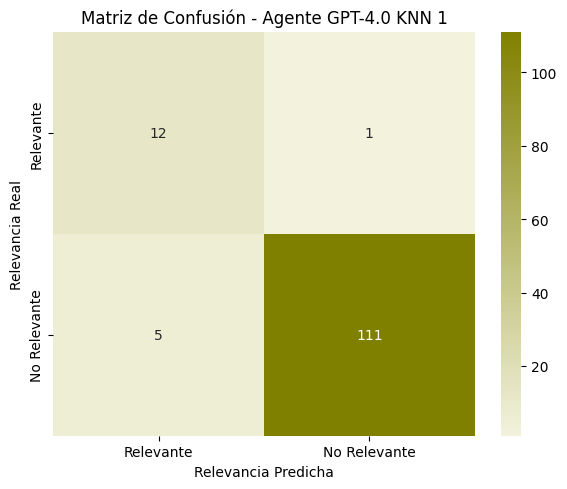

In [333]:
SUFIJO = "gpt4_knn1"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gpt = AgenteVigilante(name="Agente GPT-4.0 KNN 1", chain=chain, out_file=file_checkpoint, vectorstore=vectorstore)
av_gpt.run(df_origin,lote=10, knn=1)
av_gpt.show_report()


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente GPT-4.0 KNN 3) :
              precision    recall  f1-score   support

   relevante       0.99      0.93      0.96       116
no relevante       0.60      0.92      0.73        13

    accuracy                           0.93       129
   macro avg       0.80      0.93      0.84       129
weighted avg       0.95      0.93      0.94       129



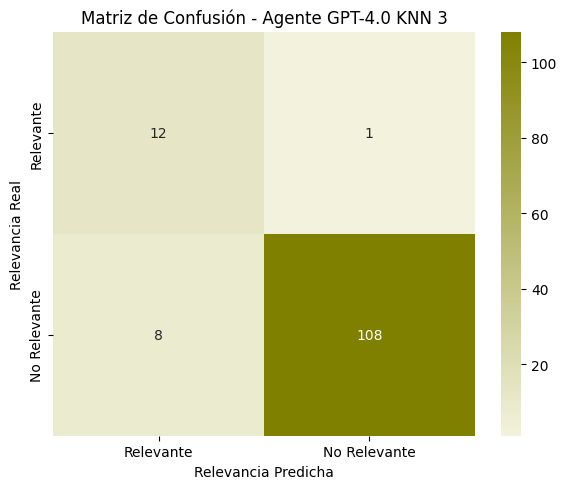

In [334]:
SUFIJO = "gpt4_knn3"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gpt= AgenteVigilante(name="Agente GPT-4.0 KNN 3", chain=chain, out_file=file_checkpoint,vectorstore=vectorstore)
av_gpt.run(df_origin,lote=10, knn=3)
av_gpt.show_report()


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente GPT-4.0 KNN 5) :
              precision    recall  f1-score   support

   relevante       0.99      0.94      0.96       116
no relevante       0.63      0.92      0.75        13

    accuracy                           0.94       129
   macro avg       0.81      0.93      0.86       129
weighted avg       0.95      0.94      0.94       129



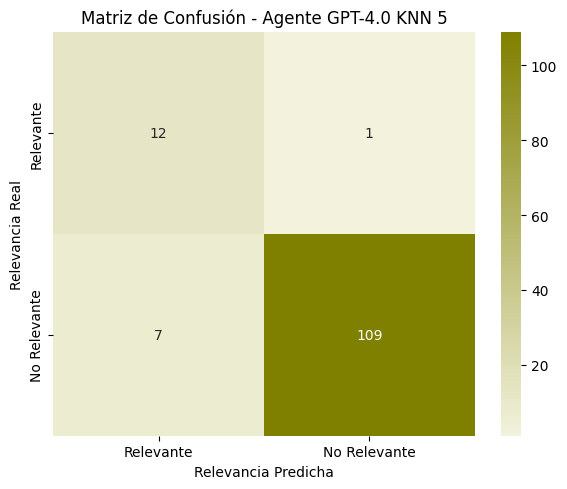

In [335]:
SUFIJO = "gpt4_knn5"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gpt = AgenteVigilante(name="Agente GPT-4.0 KNN 5", chain=chain, out_file=file_checkpoint,  vectorstore=vectorstore)
av_gpt.run(df_origin,lote=10, knn=5)
av_gpt.show_report()


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente Gemini KNN 1) :
              precision    recall  f1-score   support

   relevante       0.97      0.75      0.84       116
no relevante       0.26      0.77      0.38        13

    accuracy                           0.75       129
   macro avg       0.61      0.76      0.61       129
weighted avg       0.90      0.75      0.80       129



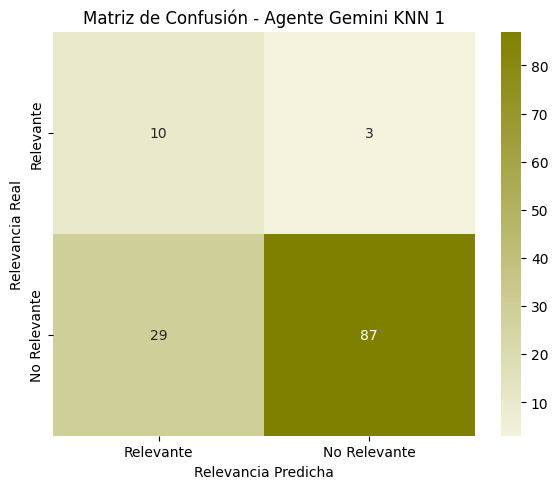

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import LLMChain

MODEL_GEMINI_KEY="AI..."
MODEL_TEMPERATURE = 0.0  # Temperatura del modelo LLM
prompt = ChatPromptTemplate.from_template(template)
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",        # o "gemini-1.5-flash", según lo que uses
    temperature=MODEL_TEMPERATURE,
    google_api_key=MODEL_GEMINI_KEY
)

chain = LLMChain(
    llm=llm,
    prompt=prompt
)

SUFIJO = "gemini_knn1"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gemini = AgenteVigilante(name="Agente Gemini KNN 1", chain=chain, out_file=file_checkpoint, vectorstore=vectorstore)
av_gemini.run(df_origin,lote=10, knn=1)
av_gemini.show_report()


In [337]:
from langchain_community.chat_models import ChatOllama
from langchain.chains import LLMChain

MODEL_TEMPERATURE = 0.0  # Temperatura del modelo LLM
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOllama(
    model="deepseek-r1:7b",             # o "ollama-r1" o "ollama-v3"
    temperature=MODEL_TEMPERATURE
)

chain = LLMChain(
    llm=llm, 
    prompt=prompt
)


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente DeepSeek KNN 1) :
              precision    recall  f1-score   support

   relevante       0.97      0.61      0.75       116
no relevante       0.20      0.85      0.32        13

    accuracy                           0.64       129
   macro avg       0.58      0.73      0.54       129
weighted avg       0.89      0.64      0.71       129



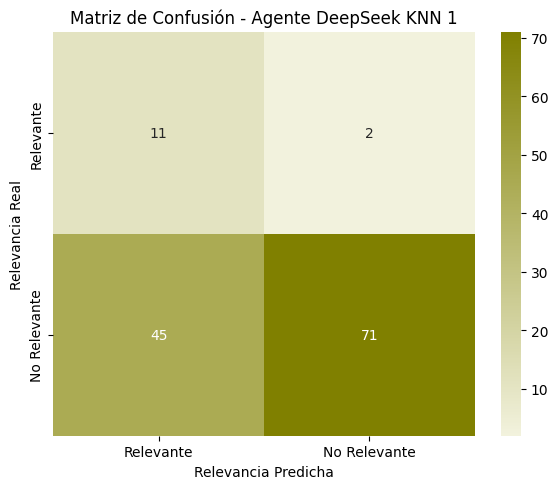

In [338]:
SUFIJO = "deepseek-r1_knn1"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_deepseek = AgenteVigilante(name="Agente DeepSeek KNN 1", chain=chain, out_file=file_checkpoint,  vectorstore=vectorstore)
av_deepseek.run(df_origin,lote=10, knn=1)
av_deepseek.show_report(normalice=True)


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente GPT-4.1 KNN 1) :
              precision    recall  f1-score   support

   relevante       0.99      0.89      0.94       116
no relevante       0.48      0.92      0.63        13

    accuracy                           0.89       129
   macro avg       0.74      0.91      0.78       129
weighted avg       0.94      0.89      0.91       129



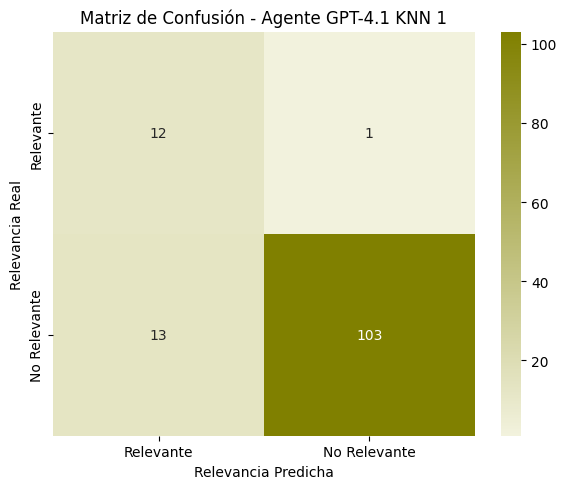

In [339]:


MODEL_GPT = "gpt-4.1-2025-04-14"  # Modelo de OpenAI para LLM
MODEL_TEMPERATURE = 0.0  # Temperatura del modelo LLM
prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    model=MODEL_GPT,
    temperature=MODEL_TEMPERATURE,
    openai_api_key=MODEL_GPT_KEY
)
chain = LLMChain(
    llm=llm,
    prompt=prompt
)

SUFIJO = "gpt4_1_knn1"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gpt41 = AgenteVigilante(name="Agente GPT-4.1 KNN 1", chain=chain, out_file=file_checkpoint,vectorstore=vectorstore)
av_gpt41.run(df_origin,lote=10, knn=1)
av_gpt41.show_report()

In [340]:
MODEL_SONNET="bedrock-api-key-YmVkcm9jay5hbWF6b25hd3MuY29tLz9BY3Rpb249Q2FsbFdpdGhCZWFyZXJUb2tlbiZYLUFtei1BbGdvcml0aG09QVdTNC1ITUFDLVNIQTI1NiZYLUFtei1DcmVkZW50aWFsPUFTSUFVSk00MkVSU0tYUU83QVdNJTJGMjAyNTA4MDMlMkZ1cy1lYXN0LTIlMkZiZWRyb2NrJTJGYXdzNF9yZXF1ZXN0JlgtQW16LURhdGU9MjAyNTA4MDNUMTc1MDE5WiZYLUFtei1FeHBpcmVzPTQzMjAwJlgtQW16LVNlY3VyaXR5LVRva2VuPUlRb0piM0pwWjJsdVgyVmpFUHIlMkYlMkYlMkYlMkYlMkYlMkYlMkYlMkYlMkYlMkZ3RWFDWFZ6TFdWaGMzUXRNaUpITUVVQ0lRQyUyRmtxOE9UTHB6MVRjZG1pNjRkbmM5RGwyVUVjbzNYTjFGeVUlMkJDZWVaNFV3SWdkZWtja0pBVU1WSXNBQ2dBNjNDenM2MyUyRkhWTXdoZEd2ZGY4TUJQS1NUOEFxcFFNSU14QUFHZ3d5T1RVd056QTVPVGsyTlRJaURGTGhCJTJGd3FKREhaMWRTdCUyQnlxQ0ExNjEwOTM4b0hnYWMlMkJqdSUyQmFjbXQwd3hjemZ2a1dra3YlMkZwak9VQzNCTkI1Q2pscXBCOHFmNjlhdGdlNUpkSFE1dVJwVzg2Wk41dlQySUIlMkY5dWxHc2NteVZkeUt3TTE4cU9ZUGtsZkdiTWllaVJza1klMkZnbGtucTVyQSUyQlNaZ3lMaG1SVDZVRjNPZktYT2xBcGwzdWtWWjdhM1pSSmslMkZ3QTNkYnF5ZzBWcU84ajJWdyUyRmtFc00zbWdRVEVEV3RhNVZBMEklMkZTTVAyWDlQTnZZZ0hBSEN4Z1VSalU0d050OW9mcFF3WmJLbVZ0cWl2NDdHR1Bhb2pUVlZFZXNKQ25ETzVHbG9kM0dNSzRXVkJISmFRQTRSc0UlMkJhNVdUQW5Fb0p3S04lMkIzQyUyRjFkTEZibVg1R0NIOWMxOVBybURFaHlBVE9rUUNNOFFoVnNndmhMWkEzMDZHMkRybE9RMG5YbDMyMjZ6VjdkRjhtUHlMaENtZWN5clNHOUFlUFdtTjVaN2ZCZmRIUmZNWnJqNFo2YWpETTVCaGx4V2NyeHptdFAwSCUyRmVDbE5oQ21TSDJ3aXBEa1lSZWVHb0FHR2ZkZ2pDNm96eDBwN0VjWXk5bzUzdHg0Z21BbkE1TW9BNW5mSE1aY3BabGZjRDN5JTJGMkFpcGQ0OWZrcnQ2JTJCWXVkdGNoSnElMkI0UlZ1cXNDTU4lMkJ5dnNRR090NENQNFZMS2s0bFhPVFBwZk9SUXBybVhhUXhkeWE0JTJCZ1AlMkZYZ0Q2amFpY1ROTENQcXZkTkVHQXh0azBOR3U0NVhvcGN4amxUVyUyQjlSczRsaWNaJTJCY3VPSmtSJTJGWDYlMkYzQjdKR0dTUmxoaGNDaUxTZWVFN1JtS1JKV2lvVUolMkZpJTJCZnpCcnAlMkZUU0FrV2JSdkVUZFhoOENkQWdtR0o4ck0lMkIlMkYxbVpXd3dXVEwxZE9md0NtT1VGJTJGdXV6JTJGZ2RSeGc0WmpIMSUyQmFMZHdOVzMlMkY4OTFzWWlObkphdUtCZW9kYWR2cnF3UEM1NHg5WEZXQjhyWVNiSWhXend1NmFVZFJlVXlWeVlINXAlMkZER0hhRzZ6WXFGOTZpcEV1cng0RXF0a3FTSEdldDIzNUt0Z0RzeGZ6SHNCVmslMkJVS2lCb3VPQllwY0xCWU5XZG55NG9FSVJ3TWNpQWFFMzBmNkJsY09yTzN3M05DR3dqMjZEUlZyQndvN3l3NEhQN1pQbXIwcnR1TW1xNnlYNUVFdlc5U2pSVXlXNEpjUTk2OWpSNm9GTkdIV2NNbHhWd051cTdZYmpjNzZzYzl6RkJpQiUyQmIxMW10JTJCdyUyQmJMd0ZXS3VuVjhNc0UwQzdTNnYyVnhMR2clM0QmWC1BbXotU2lnbmF0dXJlPTA1MjEwOWUxNDFlNjc3YTcxMTQ5YWRjOGI1N2YyMmM1NjFiMzRmMzE4NmFlZWYwZmVlMTRhOWYxMWRjMjBmN2UmWC1BbXotU2lnbmVkSGVhZGVycz1ob3N0JlZlcnNpb249MQ=="


🔄 Reanudando. Saltadas 129 normativas ya procesadas.


🔍 Clasificando normativas: 0it [00:00, ?it/s]

Reporte de clasificación (Agente GPT-4.1 Mini KNN 1) :
              precision    recall  f1-score   support

   relevante       0.99      0.91      0.95       116
no relevante       0.55      0.92      0.69        13

    accuracy                           0.91       129
   macro avg       0.77      0.92      0.82       129
weighted avg       0.95      0.91      0.92       129



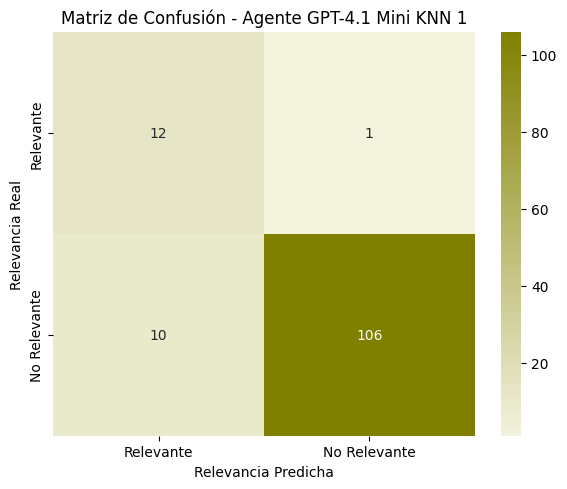

In [341]:
MODEL_GPT = "gpt-4.1-mini-2025-04-14"  # Modelo de OpenAI para LLM
MODEL_TEMPERATURE = 0.0  # Temperatura del modelo LLM
prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    model=MODEL_GPT,
    temperature=MODEL_TEMPERATURE,
    openai_api_key=MODEL_GPT_KEY
)
chain = LLMChain(
    llm=llm,
    prompt=prompt
)

SUFIJO = "gpt4_1_mini_knn1"
file_checkpoint = f"{DATA_DIR}/checkpoint_classified_regulations_{SUFIJO}.csv"
modelos_evaluados[SUFIJO] = file_checkpoint
av_gpt41 = AgenteVigilante(name="Agente GPT-4.1 Mini KNN 1", chain=chain,  out_file=file_checkpoint,  vectorstore=vectorstore)
av_gpt41.run(df_origin,lote=10, knn=1)
av_gpt41.show_report()

### 5.2.5  Visualización y reporte
- **Tablas comparativas** entre modelos.
- **Gráficos** (boxplots, violin plots, barras) para visualizar distribución de tiempos, consumo de tokens y métricas de calidad.
- **Exportación de resultados** en formato CSV y Excel para análisis posterior.

Este flujo metodológico permite **comparar diferentes configuraciones de modelos y parámetros**, facilitando la toma de decisiones para la optimización del Agente Vigilante.

In [342]:
print("Modelos evaluados y sus checkpoints:")
for modelo, checkpoint in modelos_evaluados.items():
    print(f"{modelo}: {checkpoint}")

Modelos evaluados y sus checkpoints:
gpt4_knn1: ../raw_data/checkpoint_classified_regulations_gpt4_knn1.csv
gpt4_knn3: ../raw_data/checkpoint_classified_regulations_gpt4_knn3.csv
gpt4_knn5: ../raw_data/checkpoint_classified_regulations_gpt4_knn5.csv
gemini_knn1: ../raw_data/checkpoint_classified_regulations_gemini_knn1.csv
deepseek-r1_knn1: ../raw_data/checkpoint_classified_regulations_deepseek-r1_knn1.csv
gpt4_1_knn1: ../raw_data/checkpoint_classified_regulations_gpt4_1_knn1.csv
gpt4_1_mini_knn1: ../raw_data/checkpoint_classified_regulations_gpt4_1_mini_knn1.csv


In [343]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



resultados_metricas = []
errores_globales = []

for modelo, archivo in modelos_evaluados.items():
    try:
        df = pd.read_csv(archivo)
        df["relevancia_real"] = df["relevancia_real"].astype(str).str.strip().str.lower()
        df["relevancia_predicha"] = df["relevancia_predicha"].astype(str).str.strip().str.lower()

        y_true = df["relevancia_real"]
        y_pred = df["relevancia_predicha"]

        # ✅ Calcular métricas
        accuracy = accuracy_score(y_true, y_pred) * 100
        precision = precision_score(y_true, y_pred, pos_label="relevante") * 100
        recall = recall_score(y_true, y_pred, pos_label="relevante") * 100
        f1 = f1_score(y_true, y_pred, pos_label="relevante") * 100

        resultados_metricas.append({
            "Model": modelo,
            "Accuracy": round(accuracy, 1),
            "Precision": round(precision, 1),
            "Recall": round(recall, 1),
            "F1": round(f1, 1)
        })

        # ✅ Falsos positivos
        fp = df[(y_true == "no relevante") & (y_pred == "relevante")][["nombre", "explicacion_real", "explicacion_predicha"]]
        fp["tipo_error"] = "Falso Positivo"
        fp["Modelo"] = modelo
        
        # ✅ Falsos negativos
        fn = df[(y_true == "relevante") & (y_pred == "no relevante")][["nombre", "explicacion_real", "explicacion_predicha"]]
        fn["tipo_error"] = "Falso Negativo"
        fn["Modelo"] = modelo
        
        errores_globales.append(fp)
        errores_globales.append(fn)

    except FileNotFoundError:
        print(f"⚠️ Archivo no encontrado: {archivo}")

# 📊 Consolidar métricas
df_metricas = pd.DataFrame(resultados_metricas)
print("🔹 Métricas comparativas de modelos:")
print(df_metricas)

# 📂 Consolidar errores y exportar
df_errores = pd.concat(errores_globales, ignore_index=True)
df_errores.to_csv(f"{DATA_DIR}/errores_clasificacion.csv", index=False)
print("✅ Archivo 'errores_clasificacion.csv' generado con FP y FN detallados.")


🔹 Métricas comparativas de modelos:
              Model  Accuracy  Precision  Recall    F1
0         gpt4_knn1      95.3       70.6    92.3  80.0
1         gpt4_knn3      93.0       60.0    92.3  72.7
2         gpt4_knn5      93.8       63.2    92.3  75.0
3       gemini_knn1      75.2       25.6    76.9  38.5
4  deepseek-r1_knn1      63.6       19.6    84.6  31.9
5       gpt4_1_knn1      89.1       48.0    92.3  63.2
6  gpt4_1_mini_knn1      91.5       54.5    92.3  68.6
✅ Archivo 'errores_clasificacion.csv' generado con FP y FN detallados.


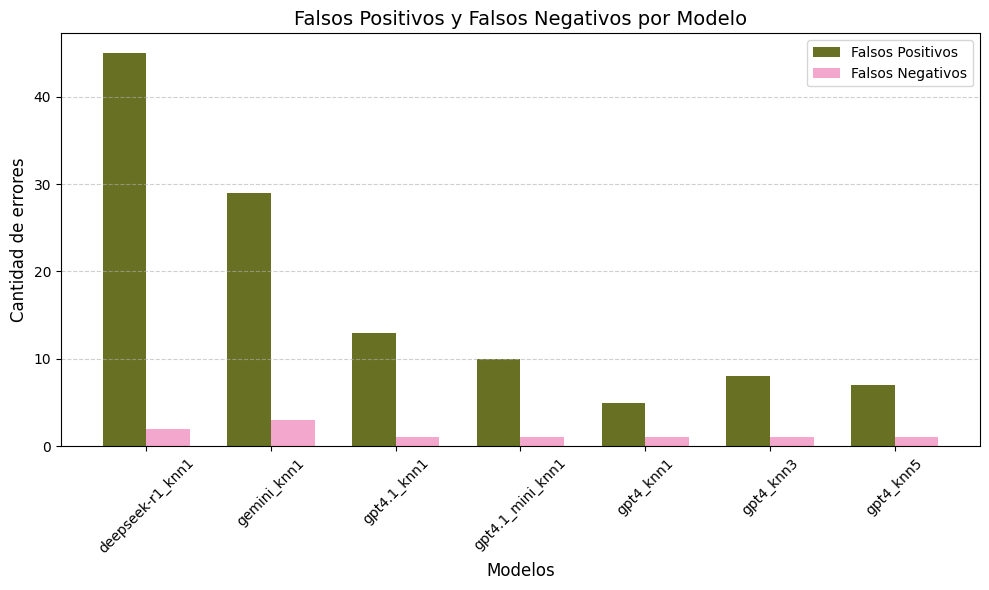

📊 Resumen de errores por modelo:
tipo_error            Modelo  Falso Negativo  Falso Positivo
0           deepseek-r1_knn1               2              45
1                gemini_knn1               3              29
2                gpt4.1_knn1               1              13
3           gpt4.1_mini_knn1               1              10
4                  gpt4_knn1               1               5
5                  gpt4_knn3               1               8
6                  gpt4_knn5               1               7


In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Cargar datos
file_path = "errores_clasificacion.csv"  # Ajusta la ruta si es necesario
df_errores = pd.read_csv(file_path)

# 2️⃣ Contar FP y FN por modelo
conteo_errores = df_errores.groupby(['Modelo', 'tipo_error']).size().unstack(fill_value=0).reset_index()

# 3️⃣ Configurar posiciones para las barras
x = np.arange(len(conteo_errores["Modelo"]))  # posiciones de los modelos
width = 0.35  # ancho de cada barra

# 4️⃣ Crear gráfico
fig, ax = plt.subplots(figsize=(10,6))
b1 = ax.bar(x - width/2, conteo_errores["Falso Positivo"], width, label='Falsos Positivos', color=CUSTOM_PALETTE[0])
b2 = ax.bar(x + width/2, conteo_errores["Falso Negativo"], width, label='Falsos Negativos', color=CUSTOM_PALETTE[1])

# 5️⃣ Opciones de formato
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Cantidad de errores', fontsize=12)
ax.set_title('Falsos Positivos y Falsos Negativos por Modelo', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(conteo_errores["Modelo"], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 6️⃣ Mostrar tabla resumen
print("📊 Resumen de errores por modelo:")
print(conteo_errores)


✅ Archivo 'resumen_tiempos_modelos.xlsx' generado con métricas.


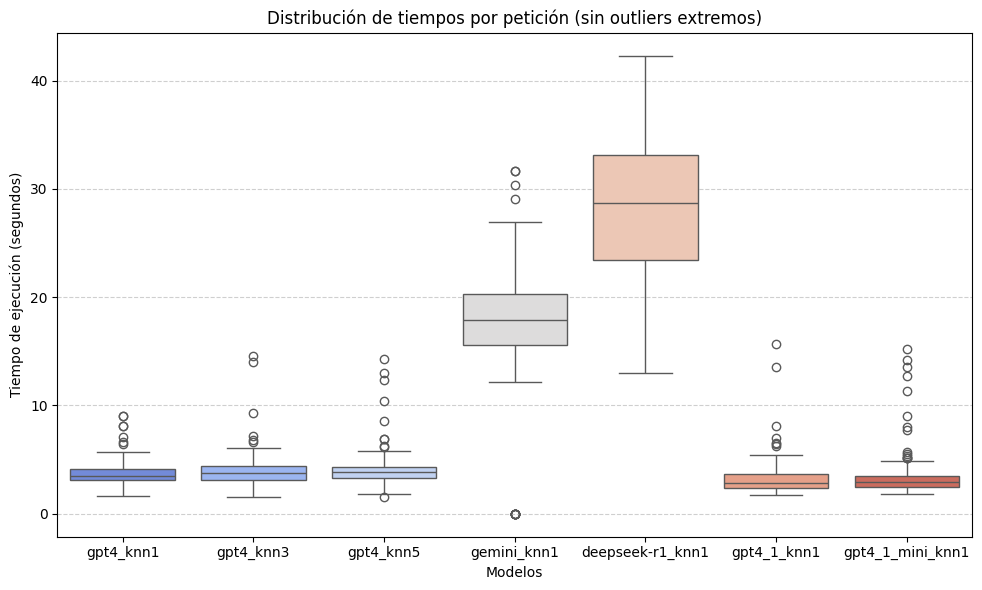

/var/folders/56/rskr5hmn5nb5nvf_7jjfrd_h0000gn/T/ipykernel_72460/2954447479.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtrado, x="Modelo", y="tiempo_ejecucion_seg", palette="coolwarm", inner="box", order=orden_modelos)


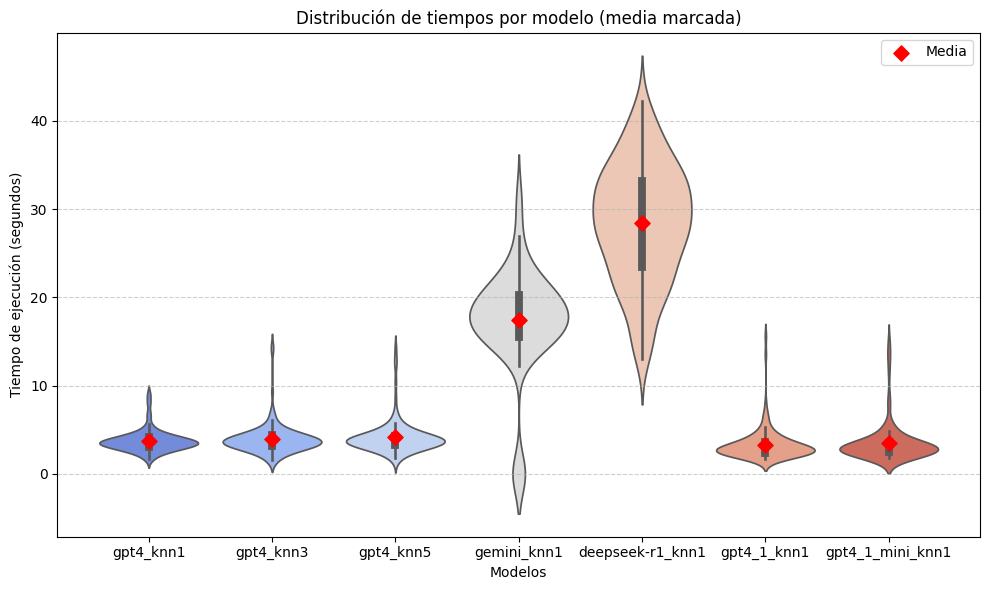

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Consolidar datos
# =======================
data_tiempos = []
for modelo, archivo in modelos_evaluados.items():
    df = pd.read_csv(archivo)
    if "tiempo_ejecucion_seg" in df.columns:
        df_tmp = df[["tiempo_ejecucion_seg"]].copy()
        df_tmp["Modelo"] = modelo
        data_tiempos.append(df_tmp)

df_tiempos = pd.concat(data_tiempos, ignore_index=True)

# =======================
# Detección de outliers (P99)
# =======================
limite = df_tiempos["tiempo_ejecucion_seg"].quantile(0.99)
df_filtrado = df_tiempos[df_tiempos["tiempo_ejecucion_seg"] <= limite]
outliers = df_tiempos[df_tiempos["tiempo_ejecucion_seg"] > limite]

# =======================
# Métricas estadísticas
# =======================
resumen = df_tiempos.groupby("Modelo")["tiempo_ejecucion_seg"].agg(
    Media="mean",
    Mediana="median",
    Desviacion_STD="std",
    Max="max",
    Min="min",
    Peticiones="count"
).reset_index()
outlier_counts = outliers.groupby("Modelo").size().rename("Outliers").reset_index()
resumen = resumen.merge(outlier_counts, on="Modelo", how="left").fillna(0)

# Guardar en Excel
resumen.to_excel("resumen_tiempos_modelos.xlsx", index=False)
print("✅ Archivo 'resumen_tiempos_modelos.xlsx' generado con métricas.")

# =======================
# Boxplot
# =======================
plt.figure(figsize=(10,6))
sns.boxplot(data=df_filtrado, x="Modelo", y="tiempo_ejecucion_seg", hue="Modelo", palette="coolwarm", dodge=False, legend=False)
plt.title("Distribución de tiempos por petición (sin outliers extremos)")
plt.ylabel("Tiempo de ejecución (segundos)")
plt.xlabel("Modelos")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =======================
# Violin plot con medias alineadas
# =======================
# Obtener el orden real de aparición de los modelos
orden_modelos = df_filtrado["Modelo"].unique()

# Calcular medias respetando el mismo orden
medias_modelos = df_filtrado.groupby("Modelo")["tiempo_ejecucion_seg"].mean().reindex(orden_modelos)

plt.figure(figsize=(10,6))
sns.violinplot(data=df_filtrado, x="Modelo", y="tiempo_ejecucion_seg", palette="coolwarm", inner="box", order=orden_modelos)

# Dibujar punto de media por modelo correctamente alineado
for i, modelo in enumerate(orden_modelos):
    plt.scatter(i, medias_modelos[modelo], color="red", marker="D", s=60, zorder=5, label="Media" if i==0 else "")

plt.title("Distribución de tiempos por modelo (media marcada)")
plt.ylabel("Tiempo de ejecución (segundos)")
plt.xlabel("Modelos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [346]:
print(modelos_evaluados)

{'gpt4_knn1': '../raw_data/checkpoint_classified_regulations_gpt4_knn1.csv', 'gpt4_knn3': '../raw_data/checkpoint_classified_regulations_gpt4_knn3.csv', 'gpt4_knn5': '../raw_data/checkpoint_classified_regulations_gpt4_knn5.csv', 'gemini_knn1': '../raw_data/checkpoint_classified_regulations_gemini_knn1.csv', 'deepseek-r1_knn1': '../raw_data/checkpoint_classified_regulations_deepseek-r1_knn1.csv', 'gpt4_1_knn1': '../raw_data/checkpoint_classified_regulations_gpt4_1_knn1.csv', 'gpt4_1_mini_knn1': '../raw_data/checkpoint_classified_regulations_gpt4_1_mini_knn1.csv'}


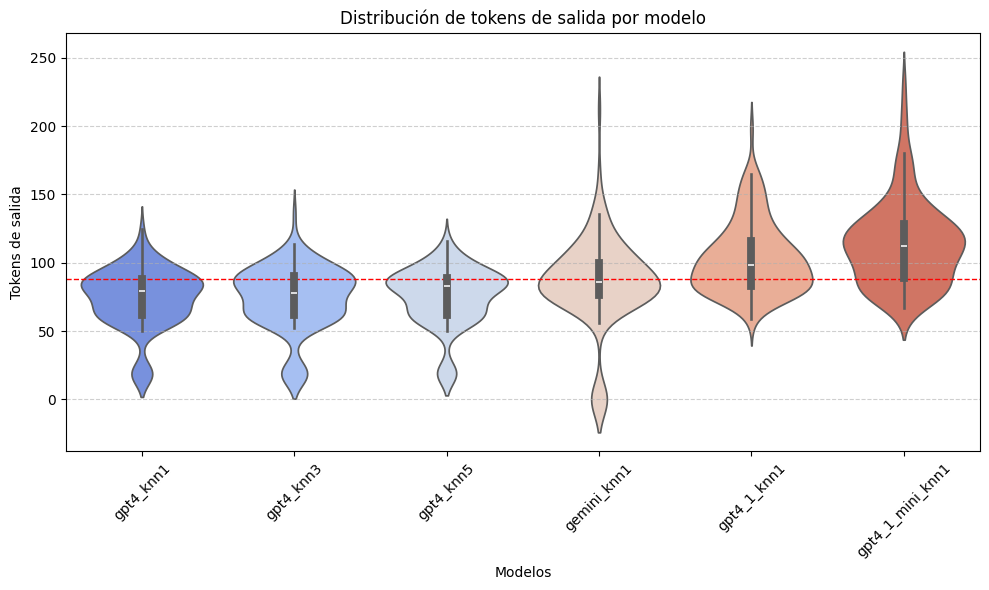

In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Diccionario de modelos (sin DeepSeek)
modelos_tokens = {
    "gpt4_knn1": "../raw_data/checkpoint_classified_regulations_gpt4_knn1.csv",
    "gpt4_knn3": "../raw_data/checkpoint_classified_regulations_gpt4_knn3.csv",
    "gpt4_knn5": "../raw_data/checkpoint_classified_regulations_gpt4_knn5.csv",
    "gemini_knn1": "../raw_data/checkpoint_classified_regulations_gemini_knn1.csv",
    "gpt4_1_knn1": "../raw_data/checkpoint_classified_regulations_gpt4_1_knn1.csv",
    "gpt4_1_mini_knn1": "../raw_data/checkpoint_classified_regulations_gpt4_1_mini_knn1.csv"
}

# Consolidar datos
data_tokens = []
for modelo, archivo in modelos_tokens.items():
    df = pd.read_csv(archivo)
    if "tokens_respuesta" in df.columns:
        df_tmp = df[["tokens_respuesta"]].copy()
        df_tmp["Modelo"] = modelo
        data_tokens.append(df_tmp)

df_tokens = pd.concat(data_tokens, ignore_index=True)

# Gráfico de violin
plt.figure(figsize=(10,6))
media_global = df_tokens["tokens_respuesta"].mean()
# Línea de promedio global
plt.axhline(media_global, color='red', linestyle='--', linewidth=1, label=f"Promedio global: {media_global:.1f} tokens")

sns.violinplot(data=df_tokens, x="Modelo", y="tokens_respuesta", palette="coolwarm",  hue="Modelo", legend=False,order=df_tokens.groupby("Modelo")["tokens_respuesta"].mean().sort_values().index)

plt.title("Distribución de tokens de salida por modelo")
plt.ylabel("Tokens de salida")
plt.xlabel("Modelos")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 5.3 Conclusiones

A partir de las pruebas y análisis realizados en este notebook, se destacan los siguientes puntos:

### 5.3.1 Desempeño de los modelos
- Los resultados obtenidos muestran diferencias significativas en términos de **precisión y estabilidad** entre los modelos evaluados.  
- Algunos modelos alcanzaron **mayor F1-score**, reflejando un mejor balance entre precisión y recall, mientras que otros presentaron mayor variabilidad y errores frecuentes (falsos positivos o negativos).

### 5.3.2 Eficiencia en tiempos de ejecución
- Se identificaron **diferencias marcadas en tiempos de respuesta** por modelo y configuración (knn), siendo algunos modelos más consistentes y rápidos, mientras que otros mostraron tiempos muy variables con presencia de outliers.

### 5.3.3 Consumo de tokens
- El consumo promedio de tokens de salida varía según el modelo, afectando el **costo computacional** y la escalabilidad del agente.
- Los modelos con prompts más extensos o respuestas más detalladas tienden a generar un mayor consumo de tokens, lo que puede impactar en entornos de uso intensivo.


---

## 5.3.4 Próximos pasos

- **Optimizar parámetros del agente**, ajustando `k` en la búsqueda semántica y el factor de truncado de tokens para mejorar precisión y tiempo de ejecución.  
- **Probar nuevos modelos o versiones**, incluyendo opciones más ligeras que mantengan la calidad de predicción.  
- **Refinar el dataset de entrenamiento y evaluación**, incluyendo ejemplos más claros de casos límite para mejorar la robustez del modelo.  


---

Estos hallazgos permitirán **seleccionar la mejor configuración de modelo y parámetros**, facilitando la futura implementación del Agente Vigilante en un entorno productivo y asegurando un equilibrio entre **precisión, eficiencia y costo operativo**.
